In [33]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics

import pyro.optim as optim
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, confusion_matrix
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy
from imblearn.under_sampling import RandomUnderSampler
import pickle
from mpl_toolkits.mplot3d import Axes3D

import scikitplot as skplt


pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.0')
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
from utils import *
from model import *

In [2]:
mode = "fast"

# Conditional Auto-Regressive Modelling of Crimes in New York City
## Rakshita Raguraman and Shruti Subramaniyam (rr3201, ss5600)

The goal of our project is to model the socio-economic and spatio-temporal crime data of New York in order to predict the potentially high-risk tracts in the city. Our problem is a binary classification problem, (1: high risk and 0: low risk). Spatial auto-correlation is the tendency for adjacent areas to share similar characteristics. Conditional Auto-Regressive (CAR) and Intrinsic Conditional Auto-Regressive (ICAR) models, first introduced by Besag (1974), account for this by pooling information from neighboring regions.

## Data Description

In order to collect the data for our analysis, we decided to use the New York Crime data. Our collection process involved merging 2 publicly available datasets and augmenting those with public buildings like restaurants and bars in the vicinity of the precinct. 

1. Crime data of New York. (data, latitude, longitude, type of crime)
2. Census data of New York. (census tract, blovk, 
3. Public spaces. (added using (latitude, longitude) pair of census data and aggregating over all the blocks to get the tract-wise information) 

## Let's have a look at the dataset

## First, let's just start with socio-economic features

In [3]:
data = data_csv('only_space')

<img src="corr.jpeg">

## Based on the above set of correlations, we decided to shorten our list of features to the following: 


In [4]:
features = ['TotalPop','Income','Poverty','Office','Construction','Production','WorkAtHome', 'PrivateWork','SelfEmployed','FamilyWork','restaurants','subway_station']

The above features were collected per census tract of New York. Based on this, we get the number of Felonies, Misdemeanors and Violations for each day. First we set number of crimes as felonies + misdemeanors + violations. Then we aggregated them for each tract by summing over all the days. Then, through empirical means, we determined a reasonable cutoff and offset which will decide whether the area is a high risk or low risk area. 

## Now let's get the dataset

In [5]:
data, X_nuts_train, y_nuts_train, month_train, X_nuts_test, y_nuts_test, month_test = get_data(data, features, bool_split=BOOL_SPLIT_SPACE, offset=OFFSET_SPACE)

In [6]:
tnse_dict = get_tnse_dict(X_nuts_train, X_nuts_test)

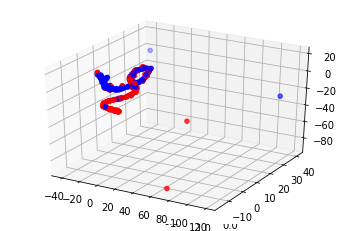

In [7]:
f = low_dim_3d(tnse_dict, y_nuts_test.numpy())

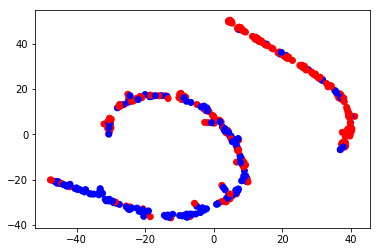

In [45]:
f = low_dim_2d(tnse_dict, y_nuts_test.numpy())

(0, 15000)

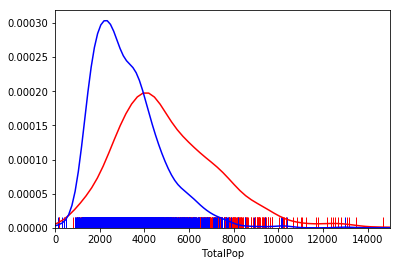

In [9]:
plt.clf()
sns.distplot(data[data['binary_target']==1]['TotalPop'], hist=False, rug=True, color='r');
sns.distplot(data[data['binary_target']==0]['TotalPop'], hist=False, rug=True, color='b');
plt.xlim(0, 15000)

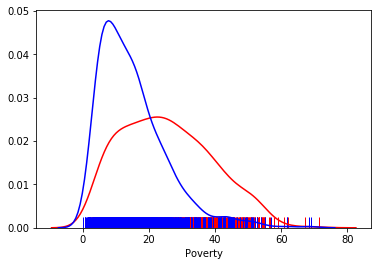

In [10]:
sns.distplot(data[data['binary_target']==1]['Poverty'], hist=False, rug=True, color='r');
sns.distplot(data[data['binary_target']==0]['Poverty'], hist=False, rug=True, color='b');

### We can observe trends in the socio-economic data & crime. Now let us look at spatial data

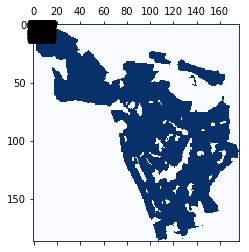

In [11]:
generate_nyc_neighbours()

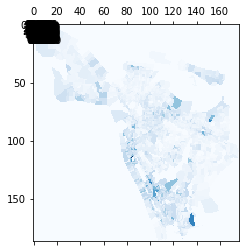

In [12]:
generate_crime_heatmap()

We can observe that there is a spatial trend as well.

## TODO: Plot binary targets

## Time data Analysis

## Modelling
Now let us get into the Modelling. First, to begin with, we ran a simple sklearn Logistic Regression model to sort of serve as a baseline. This will also give us an idea of which features have more importance than other. 

In [13]:
reg = LogisticRegression(C=0.8).fit(X_nuts_train, y_nuts_train)
print('Train Score : ',reg.score(X_nuts_train, y_nuts_train))
print('Test Score :', reg.score(X_nuts_test, y_nuts_test))
print('-'*30)

Train Score :  0.7133431085043989
Test Score : 0.7105263157894737
------------------------------


## Model 1: Baseline Bayesian Model: 

We now model a bayesian logistic regressor. The features here only depend on the socio-economic patterns, as we are now not considering time or space. 
$Y(i)$ is the binary response variable for the $i-$th tract. 
\begin{align*}
Y(i) &\sim \textrm{Bernoulli}(p(i)) \\
\textrm{Where } p(i) &\textrm{ is modelled as a logistic regressor } \\
\textrm{logit}(p(i)) &= log[\dfrac{p(i)}{1-p(i)}] \\
\textrm{logit}(p(i)) &= \beta_0 + \beta_1 x_i(i)+...+\beta_k x_k(i) \\
\end{align*}
Where $x_i$'s are the socia-economic features picked earlier

Priors are initialized as follows : 
\begin{align*}
P(\beta_i) &= N(0,10) \\
\end{align*}


In [159]:
def confidence_negative(tnse_dict, model_preds_model_1):
    feature_vector = np.array(tnse_dict['2d']['test'])
    model_preds_model_1 = np.array(model_preds_model_1)
    positives=[]
    x_positive=[]
    for i in range(len(model_preds_model_1)):
        if model_preds_model_1[i]<0.5:
            positives.append(model_preds_model_1[i])
            x_positive.append(feature_vector[i])
    x_positive = np.array(x_positive)
    plt.scatter(x_positive[:, 0], x_positive[:, 1], c=[
                (y)/256 for y in positives])
    plt.show()    

def confidence_positive(tnse_dict, model_preds_model_1):
    feature_vector = np.array(tnse_dict['2d']['test'])
    model_preds_model_1 = np.array(model_preds_model_1)
    positives=[]
    x_positive=[]
    for i in range(len(model_preds_model_1)):
        if model_preds_model_1[i]>=0.5:
            positives.append(model_preds_model_1[i])
            x_positive.append(feature_vector[i])
    x_positive = np.array(x_positive)
    plt.scatter(x_positive[:, 0], x_positive[:, 1], c=[
                (1-y)/256 for y in positives])
    plt.show()  

In [99]:
if mode=="slow":
    svi_model_1, elbo_arr_model_1 = infer(X_nuts_train, y_nuts_train, model_baseline, guide_baseline)
    model_preds_model_1, y_pred_model_1, acc_model_1 = predict(X_nuts_test, y_nuts_test, model_baseline, guide_baseline, node1=None, node2=None, month=None, num_samples=100)
else:
    d = pickle.load(open('Results_shruti/model_1_74_subset', 'rb'))
    #NOTE: uses only num_samples = 100.
    model_preds_model_1, y_pred_model_1, acc_model_1, elbo_arr_model_1 = d['model_preds'], d['y_pred'], d['acc'], d['elbo_arr']

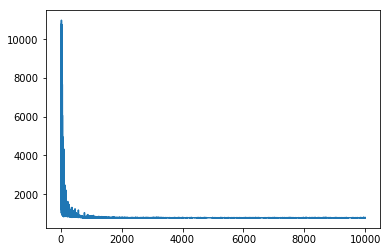

In [100]:
plt.plot(elbo_arr_model_1)

In [101]:
acc_model_1

0.7426900584795322

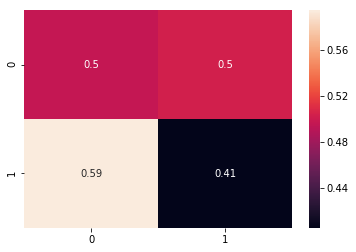

In [102]:
print_confusion_matrix(y_nuts_test, y_pred_model_1)

## Increasing number of samples from posterior for predictions

<img src="num_samples.jpeg">

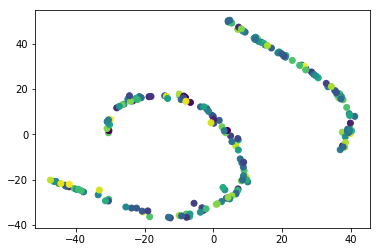

In [160]:
confidence_negative(tnse_dict, model_preds_model_1)

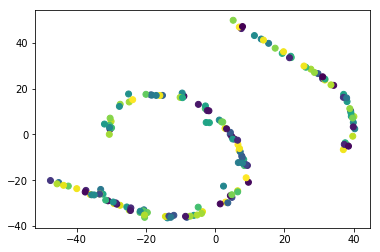

In [161]:
confidence_positive(tnse_dict, model_preds_model_1)

## Drawbacks of this model are:
We do not consider the spatial relationships at all. $Y(i)$ which is the response variable for the tract is pretty much fixed for a particular tract. So to model spatial randomness, we start off by adding unstructures spatial Gaussian noise. 

So, first, we try incorporating a random space component. This brings us to: 

## Model 2: Incorporating Random Noise

$Y(i)$ is the binary response variable for the $i-$th precinct. 
\begin{align*}
Y(i) &\sim \textrm{Bernoulli}(p(i)) \\
\textrm{Where } p(i) &\textrm{ is modelled as a logistic regressor } \\
\textrm{logit}(p(i)) &= log[\dfrac{p(i)}{1-p(i)}] \\
\textrm{logit}(p(i)) &= \beta_0 + \beta_1 x_i(i)+...+\beta_k x_k(i) + U(i) \\
U(i) &\sim N(0, \sigma_u^2)
\end{align*}\
$U(i)$ is the unstructured spatial random effect (noise) added. Without this, the limitation is $p(i)$ is fixed for each $i$.

Priors are as follows : 
\begin{align*}
P(\beta_i) &= N(0,10) \\
\tau_u &= \dfrac{1}{\sigma_u^2} \\
P(\tau_u) &= \textrm{Gamma} (0.001,0.001) \\
\end{align*}

Due to some difficulties with nan loss we had with Pyro and with some suggestions we got online, we increased Gamma prioirs to 0.5.

In [85]:
if mode=="slow":
    num_samples = 100
    svi_model_2, elbo_arr_model_2 = infer(X_nuts_train, y_nuts_train, model_baseline, guide_baseline)
    model_preds_model_2, y_pred_model_2, acc_model_2 = predict(X_nuts_test, y_nuts_test, model_2, guide_2, node1=None, node2=None, month=None, num_samples=100)
    pickle_it(model_preds_model_2, y_pred_model_2, acc_model_2, elbo_arr_model_2, "model_2_{}_subset_{}".format(acc_model_2, num_samples))
else:
    d = pickle.load(open('Results_shruti/model_2_70_subset_100', 'rb'))
    #NOTE: uses only num_samples = 100.
    model_preds_model_2, y_pred_model_2, acc_model_2, elbo_arr_model_2 = d['model_preds'], d['y_pred'], d['acc'], d['elbo_arr']

In [89]:
acc_model_2

0.7076023391812866

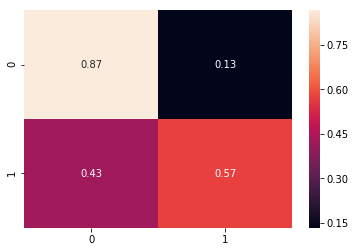

In [97]:
print_confusion_matrix(y_nuts_test, y_pred_model_2)

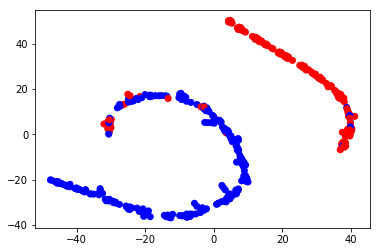

In [90]:
f = low_dim_2d(tnse_dict, y_pred_model_2)

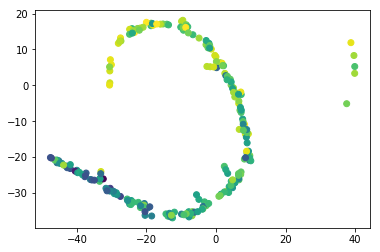

In [162]:
confidence_negative(tnse_dict, model_preds_model_2)

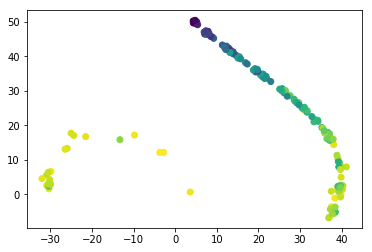

In [163]:
confidence_positive(tnse_dict, model_preds_model_2)

# Model 3 : Using ICAR Model for structured spatial noise

$Y(i)$ is the binary response variable for the $i-$th precinct. 
\begin{align*}
Y(i) &\sim \textrm{Bernoulli}(p(i)) \\
\textrm{Where } p(i) &\textrm{ is modelled as a logistic regressor } \\
\textrm{logit}(p(i)) &= log[\dfrac{p(i)}{1-p(i)}] \\
\textrm{logit}(p(i)) &= \beta_0 + \beta_1 x_i(i)+...+\beta_k x_k(i) + U(i) + \phi(i) \\
U(i) &\sim N(0, \sigma_u^2)
\end{align*} \
$U(i)$ is the unstructured spatial random effect (noise) added. Without this, the limitation is $p(i)$ is fixed for each $i$. \
\begin{align*}
p(\phi_i|\phi_j) &= N\left(\frac{\sum_{i \sim j} \phi_i}{d_i}, \frac{\sigma_s^2(i)}{d_i}\right)    \\
\end{align*} \
Here $i \sim j$ means that node $j$ in a neighbor of node $i$ and $ i \neq j$ and $d_i$ denotes number of neighbors of tract/node $i$. \
This encodes the relationship that neighbouring precincts have on each other.\
The joint of $\phi$ with **zero mean and unit variance** is:
\begin{align*}
p(\phi) &\propto exp \left( -\frac{1}{2} \sum_{i \sim j}(\phi_i - \phi_j)^2\right)  \\
mean(\phi) &= \frac{\sum_N{\phi_i}}{N} = 0 \\
&\implies sum(\phi) = 0
\end{align*}


Priors are as follows : 
\begin{align*}
P(\beta_i) &= N(0,10) \\
\tau_u &= \dfrac{1}{\sigma_u^2} \\
\tau_w &= \dfrac{1}{\sigma_s^2} \\
P(\tau_u) &= \textrm{Gamma} (0.001,0.001) \\
\end{align*}

